# Forecasting :
***Problem Statement :***
- Forecast the CocaCola prices data set. 
- Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model.    
- Finally which model you will use for Forecasting.


In [50]:
# Importing usefull libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import (SimpleExpSmoothing, Holt, ExponentialSmoothing)
from statsmodels.tsa.arima.model import (ARIMA, ARIMAResults)
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt

# Ignore anoying warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading CocaCola dataset
coke = pd.read_excel("CocaCola_Sales_Rawdata.xlsx", index_col=0, parse_dates=True)

# Showing first 5 rows from given dataset
coke.head()

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996


In [3]:
# Dimensions of given dataset
coke.shape

(42, 1)

In [4]:
# Summary of dataset
coke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, Q1_86 to Q2_96
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   42 non-null     float64
dtypes: float64(1)
memory usage: 672.0+ bytes


In [5]:
# Looking for null values
coke.isna().any().any()

False

In [6]:
# Checking basic stats
coke.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [7]:
# Looking for duplicate values
coke.duplicated().any()

False

In [8]:
# Index values
coke.index

Index(['Q1_86', 'Q2_86', 'Q3_86', 'Q4_86', 'Q1_87', 'Q2_87', 'Q3_87', 'Q4_87',
       'Q1_88', 'Q2_88', 'Q3_88', 'Q4_88', 'Q1_89', 'Q2_89', 'Q3_89', 'Q4_89',
       'Q1_90', 'Q2_90', 'Q3_90', 'Q4_90', 'Q1_91', 'Q2_91', 'Q3_91', 'Q4_91',
       'Q1_92', 'Q2_92', 'Q3_92', 'Q4_92', 'Q1_93', 'Q2_93', 'Q3_93', 'Q4_93',
       'Q1_94', 'Q2_94', 'Q3_94', 'Q4_94', 'Q1_95', 'Q2_95', 'Q3_95', 'Q4_95',
       'Q1_96', 'Q2_96'],
      dtype='object', name='Quarter')

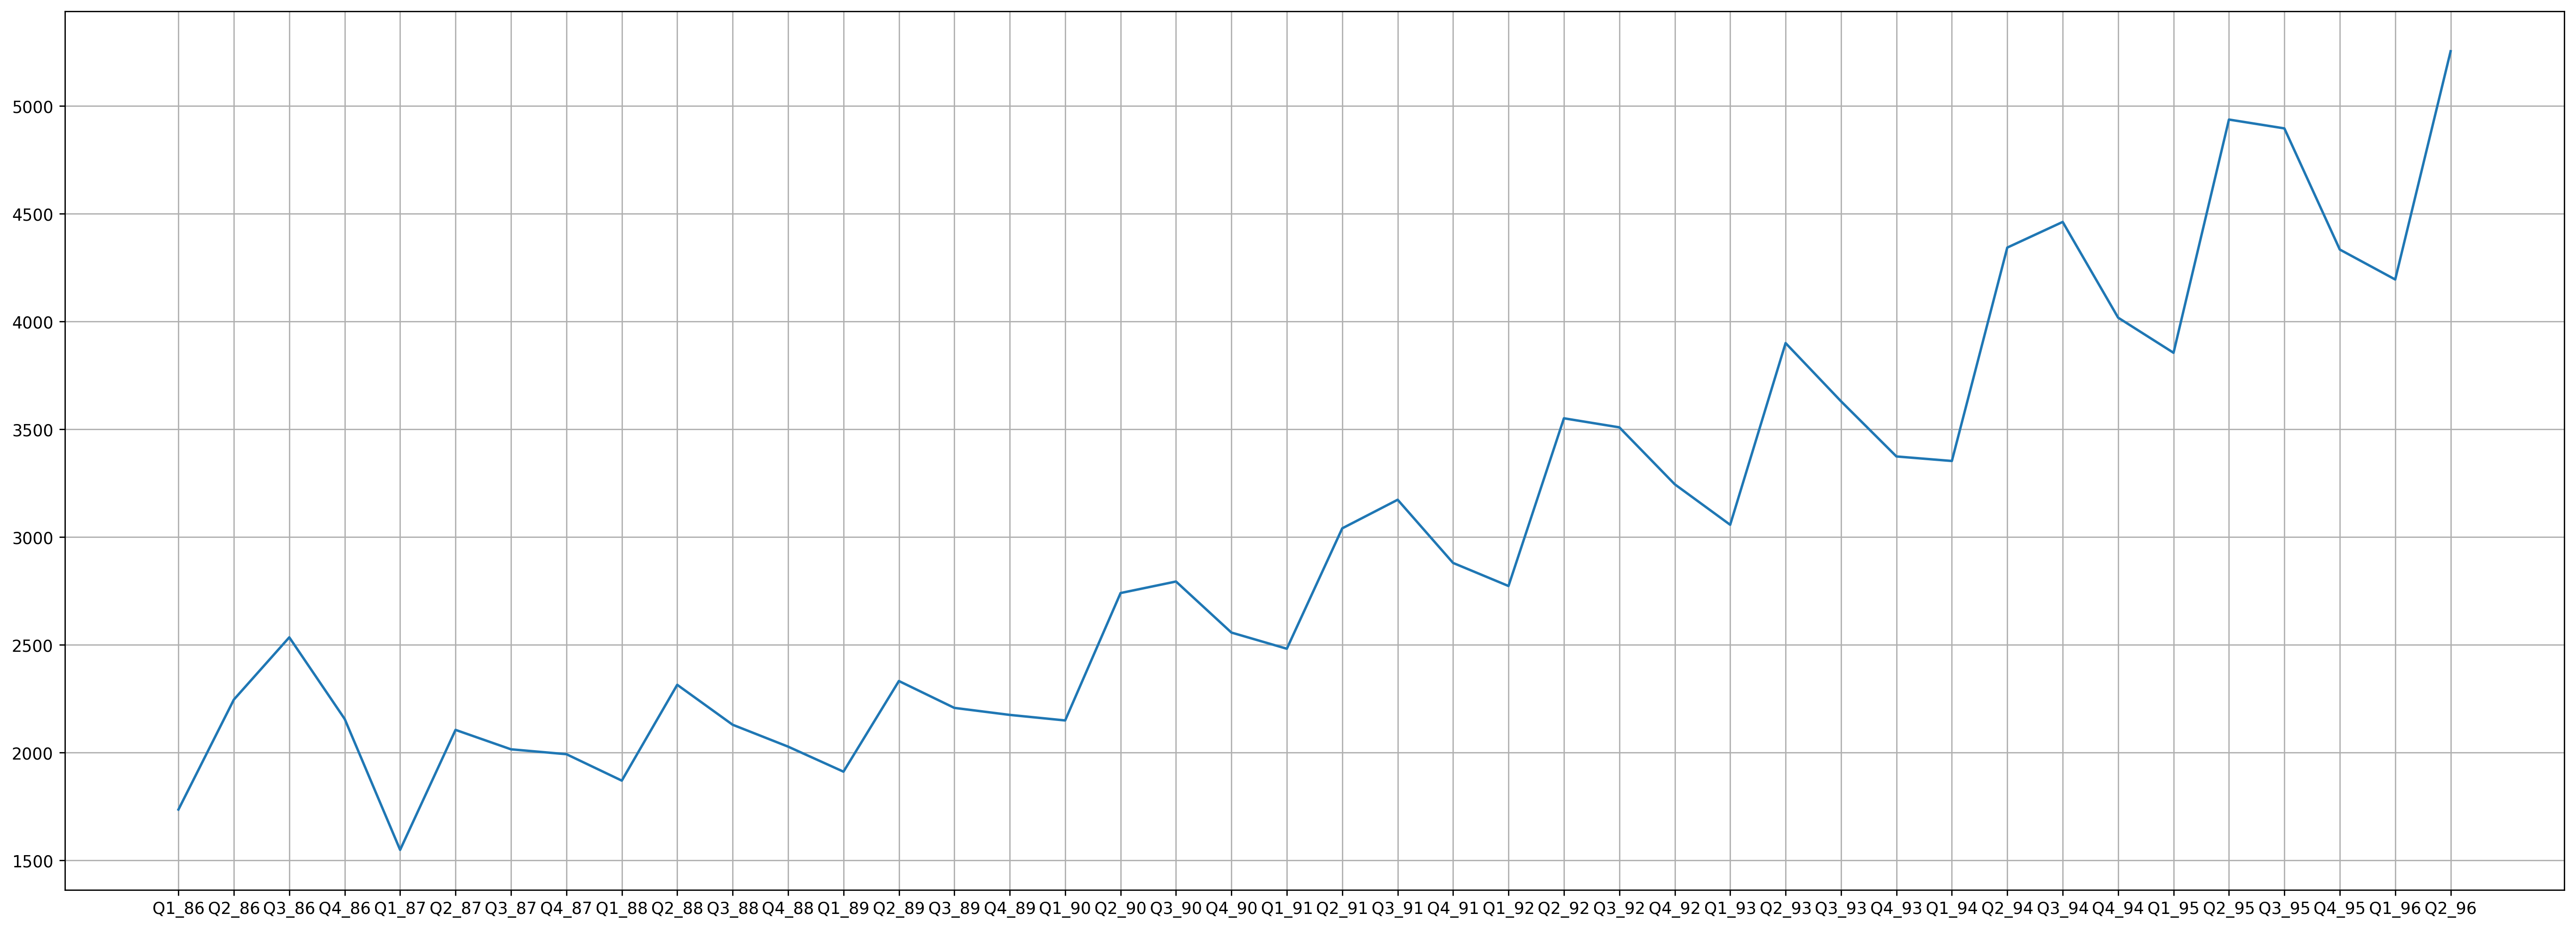

In [9]:
plt.figure(figsize=(22,8),dpi=250)
plt.plot(coke)
plt.grid()
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='Sales', ylabel='Density'>

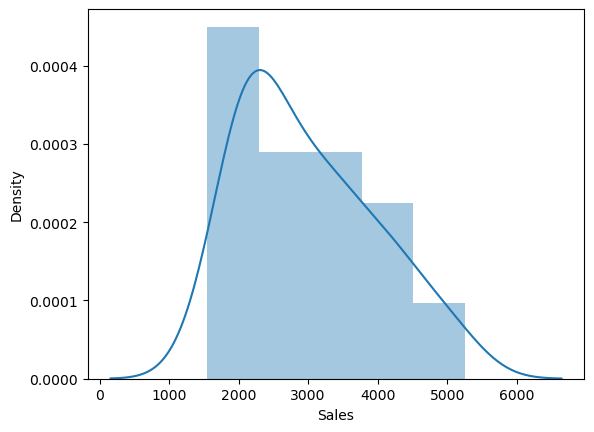

In [10]:
# Checking distribution of "Sales" column
sns.distplot(coke['Sales'])

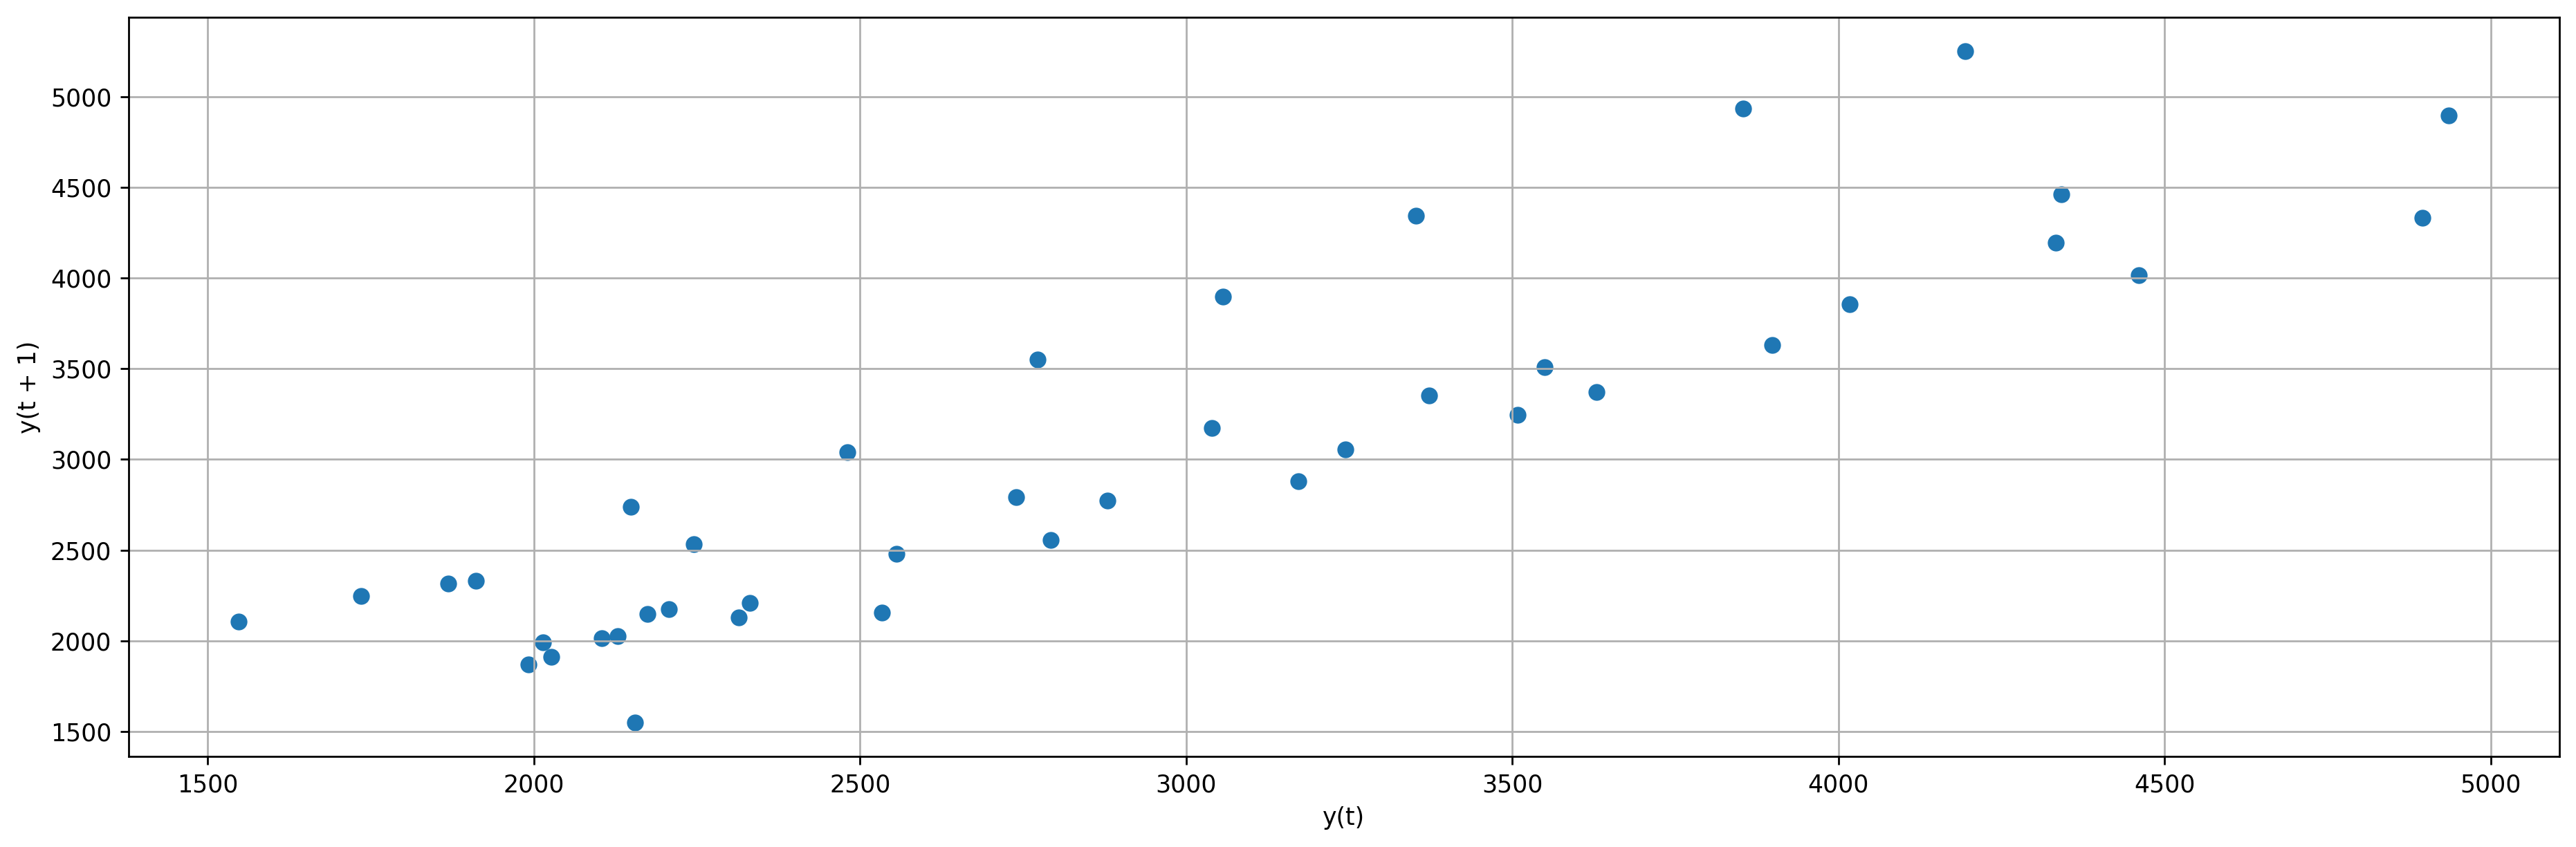

In [11]:
# Plotting Lag plot for time series.
plt.figure(figsize=(15,5),dpi=250)
pd.plotting.lag_plot(coke)
plt.grid()
plt.tight_layout()
plt.show()

<Figure size 2500x1250 with 0 Axes>

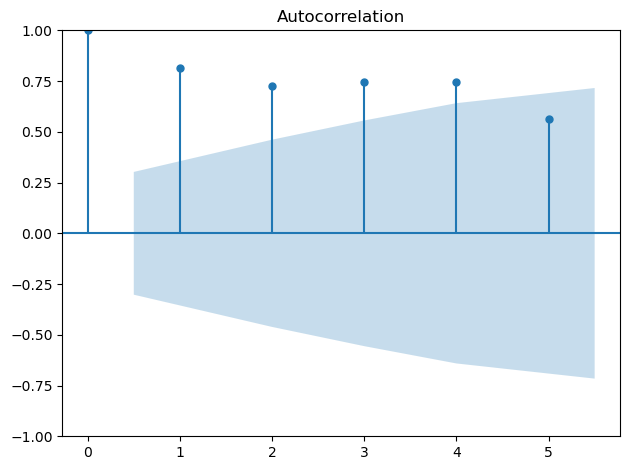

In [12]:
# Plotting the autocorrelation function
# Plotting lags on the horizontal and the correlations on vertical axis.
plt.figure(figsize=(10,5),dpi=250)
plot_acf(coke, lags=5)
plt.tight_layout()
plt.show()

In [13]:
coke = pd.read_excel("CocaCola_Sales_Rawdata.xlsx", parse_dates=True)
coke.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [14]:
# Adding extra Quarter_2 column like [Q1,Q2,Q3,Q4]
Quarter_2 = ["Q1,Q2,Q3,Q4"]

p = coke['Quarter'][0]
p[0:2]
coke['Quarter_2']=0

for i in range(42):
    p = coke['Quarter'][i]
    coke['Quarter_2'][i]=p[0:2]
    
coke.head()

,Quarter,Sales,Quarter_2
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [15]:
# Creating only "Quarter_2" column dummy variables
q_dummy = pd.DataFrame(pd.get_dummies(coke['Quarter_2']))
q_dummy.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [16]:
# Adding created dataframe to main dataset
coke = pd.concat([coke,q_dummy],axis=1)
coke.head()

,Quarter,Sales,Quarter_2,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [17]:
# Creating a complete dataset
# Adding "t" column
coke['t'] = np.arange(1,43)

# Adding "t-square" column which gives element-wise square of the input
coke['t_square'] = np.square(coke.t)

# Adding "Sales_log" column which is log of "Sales" column
coke["Sales_log"] = np.log(coke.Sales)

# Showing dataset
coke.head()

,Quarter,Sales,Quarter_2,Q1,Q2,Q3,Q4,t,t_square,Sales_log
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602


In [18]:
# Dimensions of dataset
coke.shape

(42, 10)

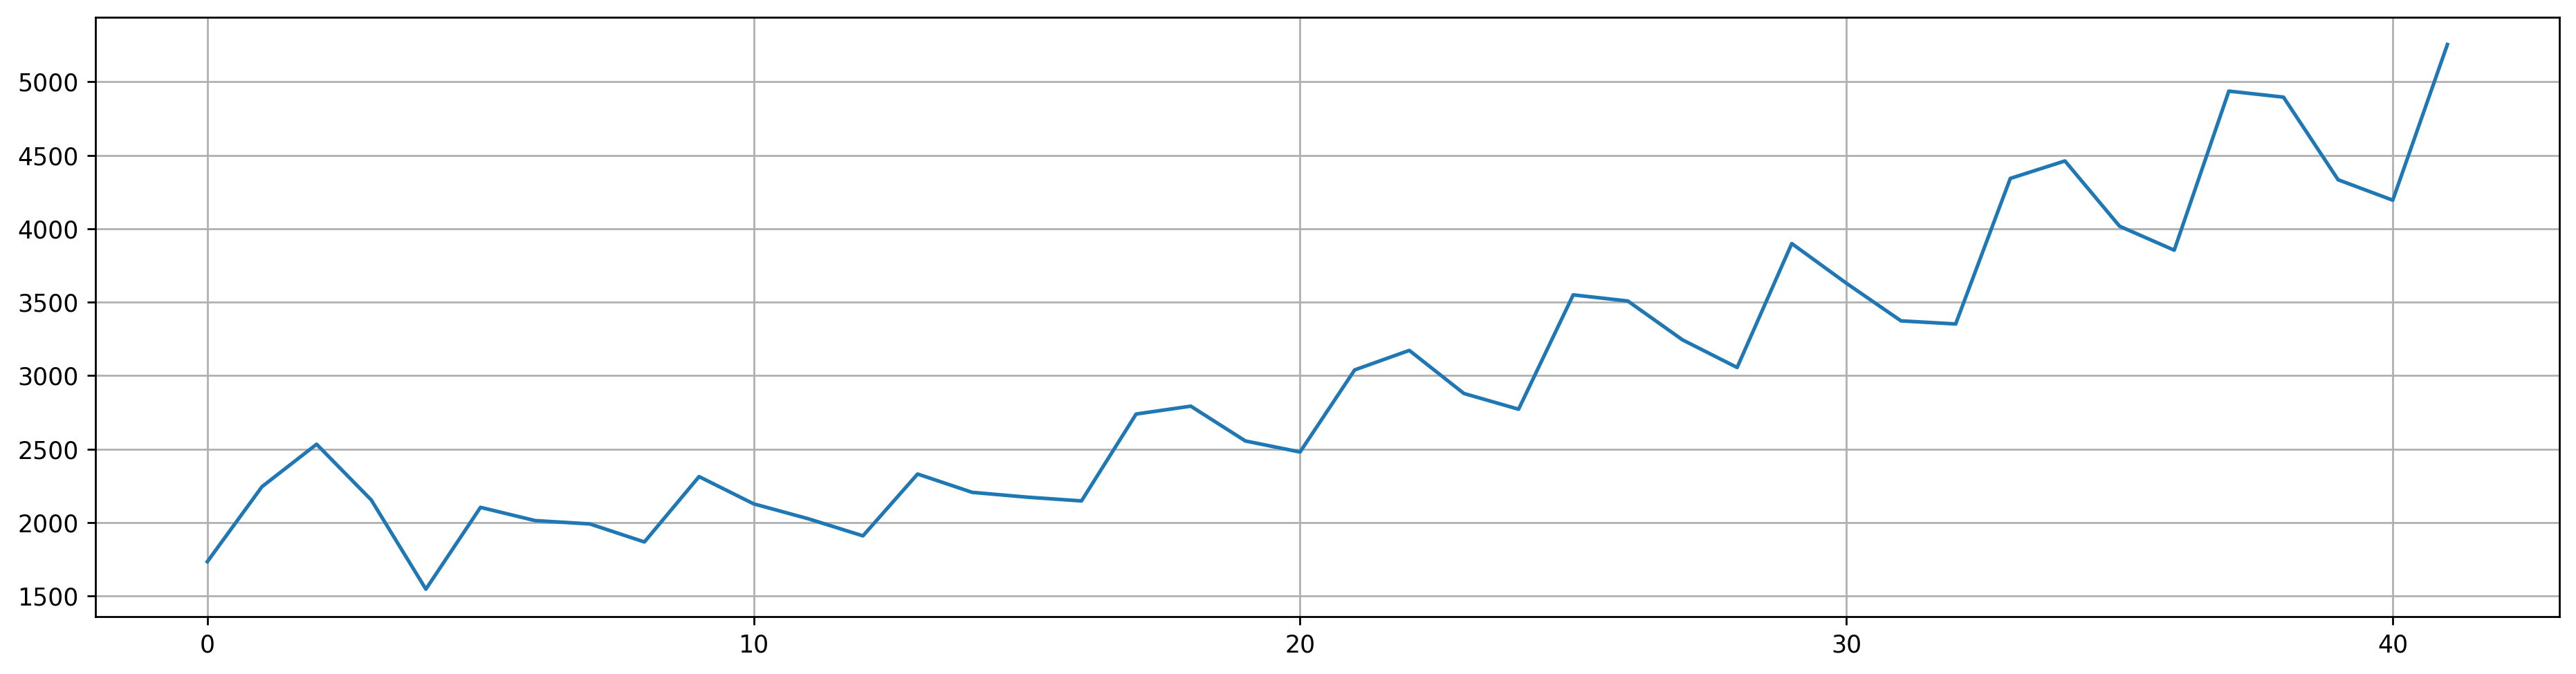

In [19]:
plt.figure(figsize=(15,4),dpi=250)
plt.plot(coke['Sales'])
plt.grid()
plt.tight_layout()
plt.show()

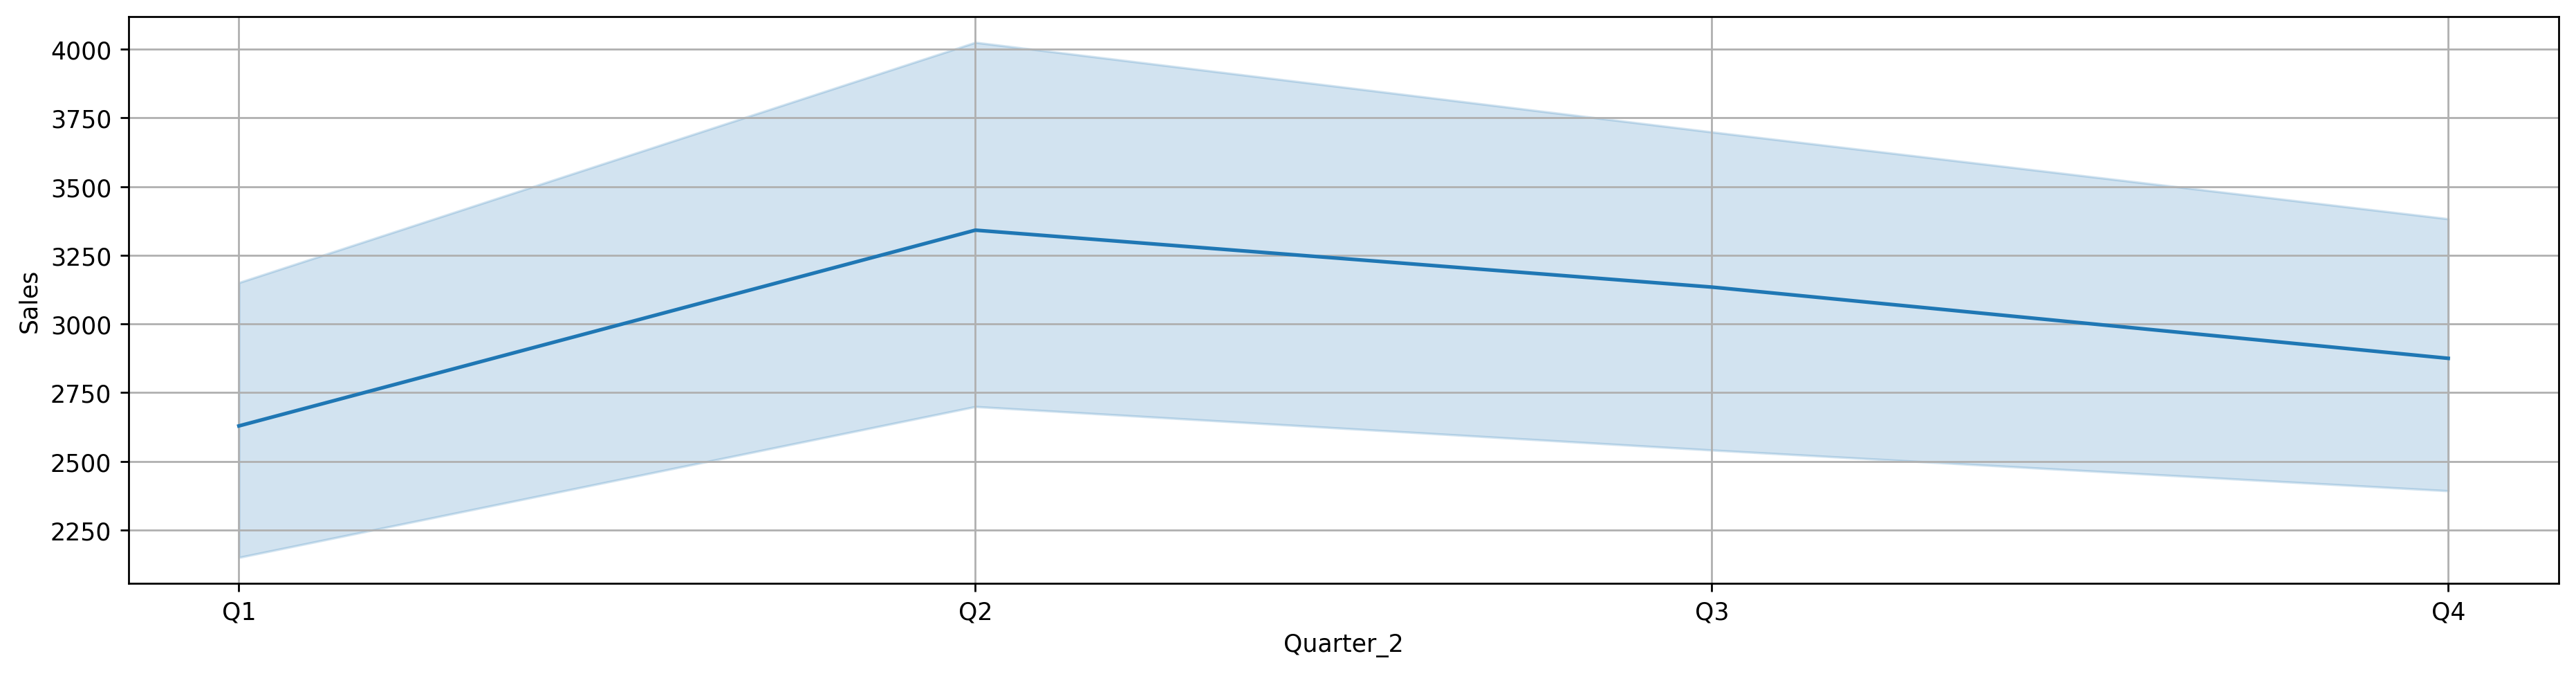

In [20]:
# Drawing a line plot with possibility of several semantic groupings.
plt.figure(figsize=(15,4),dpi=250)
sns.lineplot(x=coke['Quarter_2'], y=coke['Sales'], data=coke)
plt.grid()
plt.tight_layout()
plt.show()

In [21]:
# Splitting data into train test sets
train = coke.head(35)
test = coke.tail(7)

In [22]:
# Dimensions of train & test sets
print("Train set :",train.shape)
print("Test set :",test.shape)

Train set : (35, 10)
Test set : (7, 10)


**Linear Model :**

In [23]:
linear_model = smf.ols("Sales~t", data=train).fit()
linear_pred = pd.Series(linear_model.predict(pd.DataFrame(test['t'])))

# Calculating Root Mean Squared Error (RMSE) value
linear_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(linear_pred))**2))
print('RMSE :',linear_rmse)

RMSE : 636.5072930351143


**Exponential Model :**

In [24]:
exp_model = smf.ols('Sales_log~t', data=train).fit()
exp_pred = pd.Series(exp_model.predict(pd.DataFrame(test['t'])))

# Calculating Root Mean Squared Error (RMSE) value
exp_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(exp_pred)))**2)) 
print('RMSE :',exp_rmse)

RMSE : 493.34864848421216


**Quadratic Model :**

In [26]:
quad_model = smf.ols('Sales~t+t_square', data=train).fit()
quad_pred = pd.Series(quad_model.predict(test[['t','t_square']]))

# Calculating Root Mean Squared Error (RMSE) value
quad_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(quad_pred))**2))
print('RMSE :',quad_rmse)

RMSE : 511.81173194173414


**Additive Seasonality Model :**

In [27]:
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4', data=train).fit()
add_sea_pred = pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))

# Calculating Root Mean Squared Error (RMSE) value
add_sea_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(add_sea_pred))**2))
print('RMSE :',add_sea_rmse)

RMSE : 1861.8704164251737


**Additive Seasonality Quadratic Model :**

In [28]:
add_sea_Quad = smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
add_sea_quad_pred = pd.Series(add_sea_Quad.predict(test[['Q1','Q2','Q3','Q4','t','t_square']]))

# Calculating Root Mean Squared Error (RMSE) value
add_sea_quad_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(add_sea_quad_pred))**2))
print('RMSE :',add_sea_quad_rmse)

RMSE : 309.46413951642717


**Multiplicative Seasonality Model :**

In [29]:
mul_sea = smf.ols('Sales_log~Q1+Q2+Q3+Q4', data=train).fit()
mult_sea_pred = pd.Series(mul_sea.predict(test))

# Calculating Root Mean Squared Error (RMSE) value
mult_sea_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(mult_sea_pred)))**2))
print('RMSE :',mult_sea_rmse)

RMSE : 1938.9332351966098


**Multiplicative Additive Seasonality Model :**

In [30]:
mult_add_sea = smf.ols('Sales_log~t+Q1+Q2+Q3+Q4', data=train).fit()
mult_add_sea_pred = pd.Series(mult_add_sea.predict(test))

# Calculating Root Mean Squared Error (RMSE) value
mult_add_sea_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(mult_add_sea_pred)))**2))
print('RMSE :',mult_add_sea_rmse)

RMSE : 339.1874666994897


**Multiplicative Seasonality Quadratic Model :**

In [31]:
mult_sea_quad = smf.ols('Sales_log~t+t_square+Q1+Q2+Q3+Q4', data=train).fit()
mult_sea_quad_pred = pd.Series(mult_sea_quad.predict(test[['Q1','Q2','Q3','Q4','t','t_square']]))

# Calculating Root Mean Squared Error (RMSE) value
mult_sea_quad_rmse = np.sqrt(np.mean((np.array(test['Sales'])-np.array(mult_sea_quad_pred))**2))
print('RMSE :',mult_sea_quad_rmse)

RMSE : 4515.6247384401395


**All models & their RMSE values :**

In [32]:
data = {
    "Linear Model":linear_rmse,
    "Exponential Model":exp_rmse,
    "Quadratic Model":quad_rmse,
    "Additive Seasonality Model":add_sea_rmse,
    "Additive Seasonality Quadratic Model":add_sea_quad_rmse,
    "Multiplicative Seasonality Model":mult_sea_rmse,
    "Multiplicative Addative Seasonality Model":mult_add_sea_rmse,
    "Multiplicative Seasonality Quadratic Model":mult_sea_quad_rmse
}

# Creating dataframe
RMSE = pd.DataFrame.from_dict(data, orient='index', columns=['RMSE'])
RMSE.reset_index(inplace=True)
RMSE.rename(columns={'index':'MODEL'}, inplace=True)

In [33]:
RMSE

,MODEL,RMSE
0,Linear Model,636.507293
1,Exponential Model,493.348648
2,Quadratic Model,511.811732
3,Additive Seasonality Model,1861.870416
4,Additive Seasonality Quadratic Model,309.464140
5,Multiplicative Seasonality Model,1938.933235
6,Multiplicative Addative Seasonality Model,339.187467
7,Multiplicative Seasonality Quadratic Model,4515.624738


# Final Model Building :

In [35]:
# Model building for entire dataset
final_model = smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4', data=coke).fit()

# Prediction
final_pred = pd.Series(final_model.predict(coke))
final_pred

0     1626.592727
1     2268.402339
2     2189.685821
3     1867.242917
4     1658.311143
5     2314.185178
6     2249.533083
7     1941.154603
8     1746.287252
9     2416.225709
10    2365.638037
11    2071.323979
12    1890.521051
13    2574.523931
14    2538.000682
15    2257.751047
16    2091.012542
17    2789.079845
18    2766.621019
19    2500.435807
20    2347.761724
21    3059.893450
22    3051.499047
23    2799.378257
24    2660.768598
25    3386.964746
26    3392.634766
27    3154.578400
28    3030.033163
29    3770.293734
30    3790.028177
31    3566.036233
32    3455.555419
33    4209.880414
34    4243.679279
35    4033.751758
36    3937.335367
37    4705.724784
38    4753.588072
39    4557.724974
40    4475.373006
41    5257.826846
dtype: float64

In [37]:
coke['Forecasted_Sales'] = pd.Series(final_pred)
coke.head()

,Quarter,Sales,Quarter_2,Q1,Q2,Q3,Q4,t,t_square,Sales_log,Forecasted_Sales
0,Q1_86,1734.827000,Q1,1,0,0,0,1,1,7.458663,1626.592727
1,Q2_86,2244.960999,Q2,0,1,0,0,2,4,7.716443,2268.402339
2,Q3_86,2533.804993,Q3,0,0,1,0,3,9,7.837477,2189.685821
3,Q4_86,2154.962997,Q4,0,0,0,1,4,16,7.675529,1867.242917
4,Q1_87,1547.818996,Q1,1,0,0,0,5,25,7.344602,1658.311143


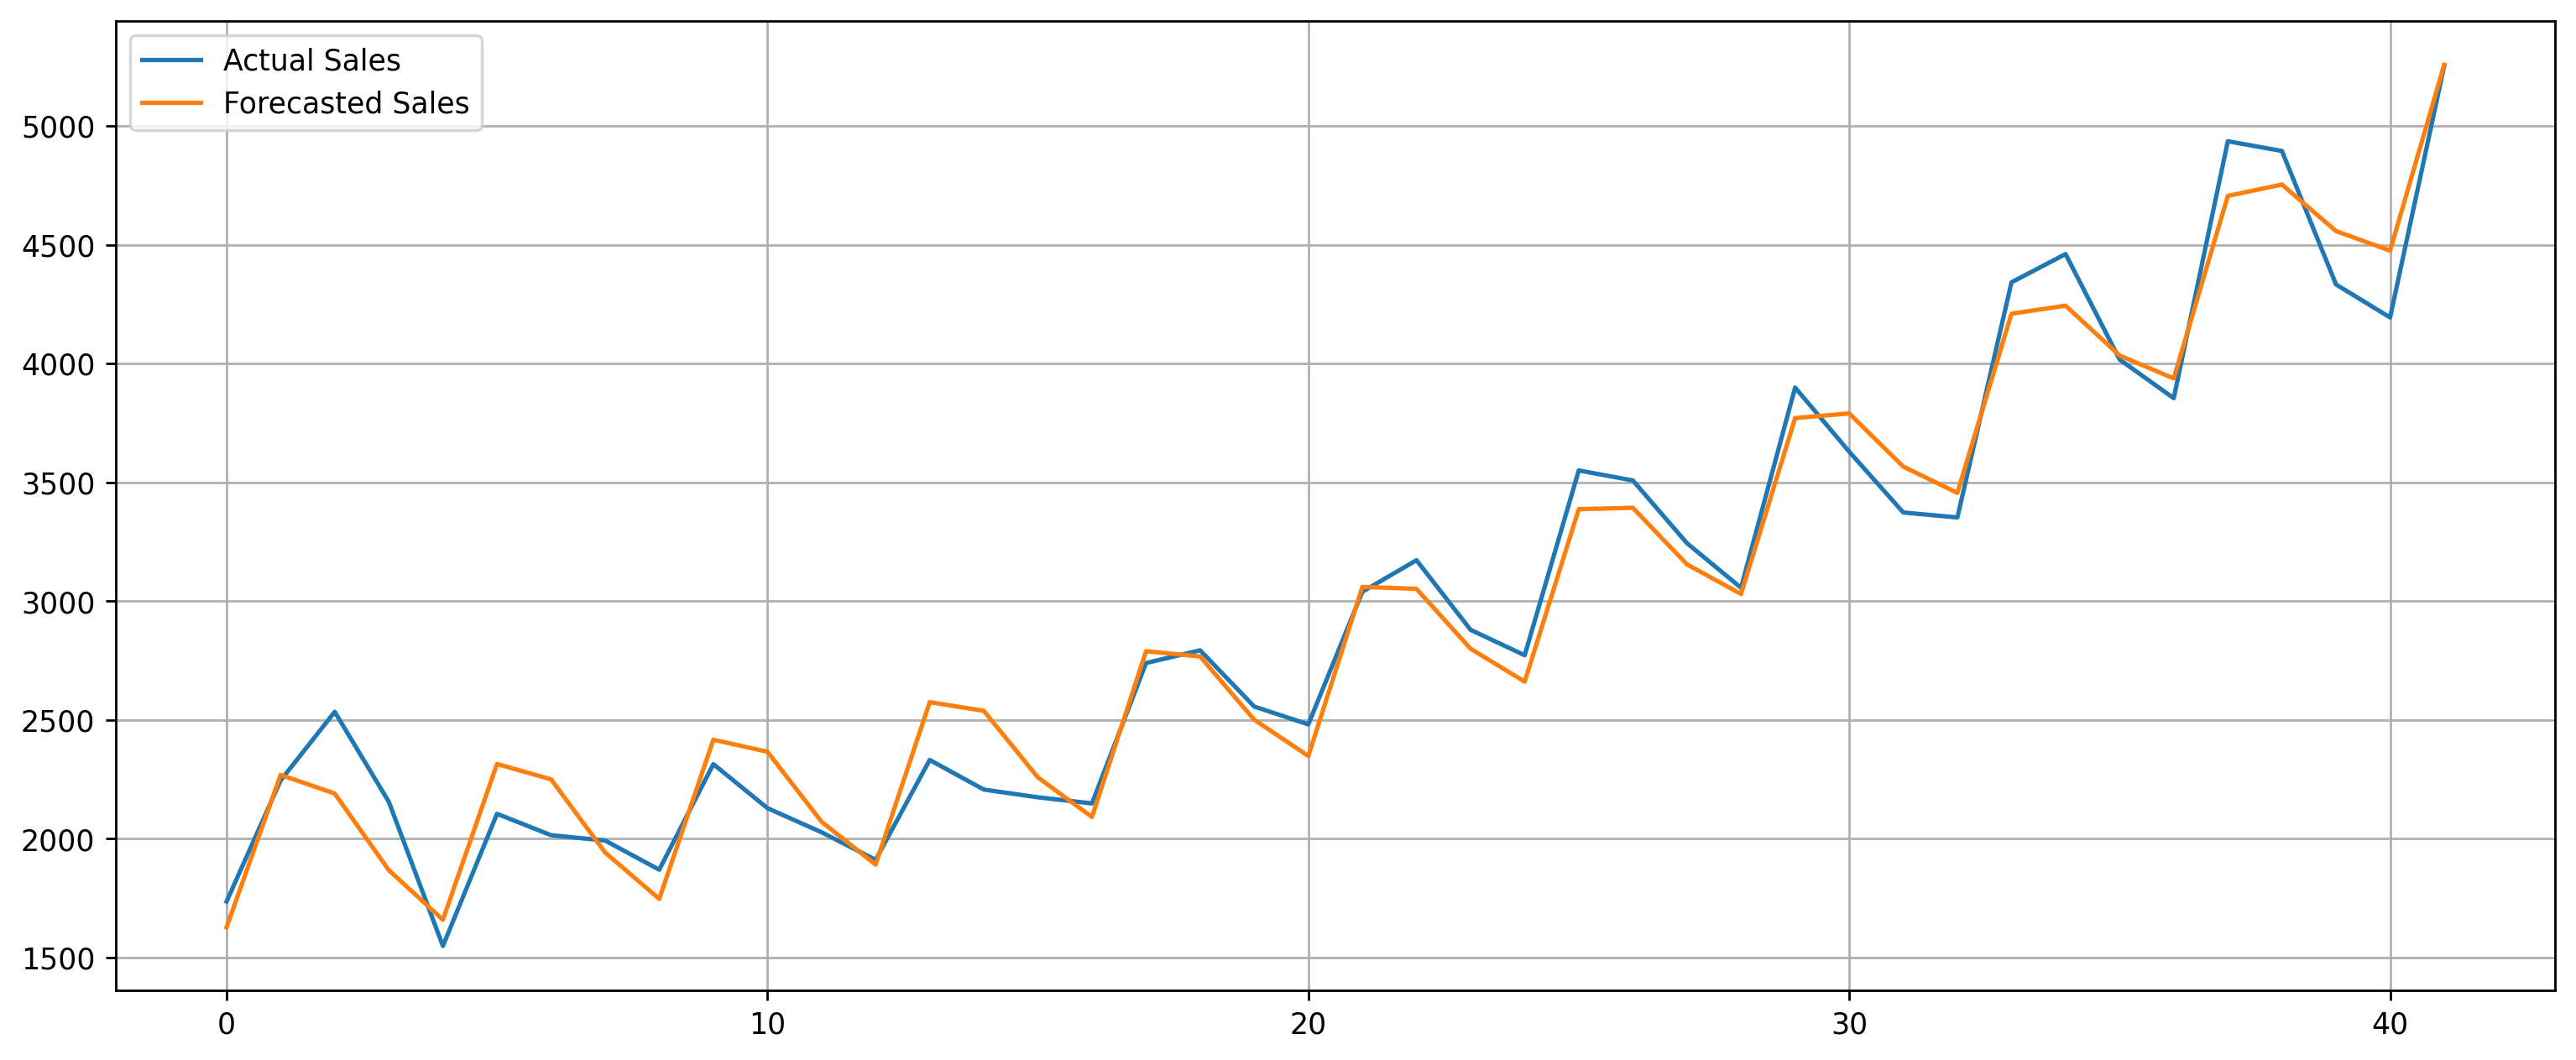

In [44]:
plt.figure(figsize=(15,6), dpi=250)
plt.plot(coke["Sales"], label="Actual Sales")
plt.plot(coke["Forecasted_Sales"], label="Forecasted Sales")
plt.grid()
plt.legend()
plt.show()

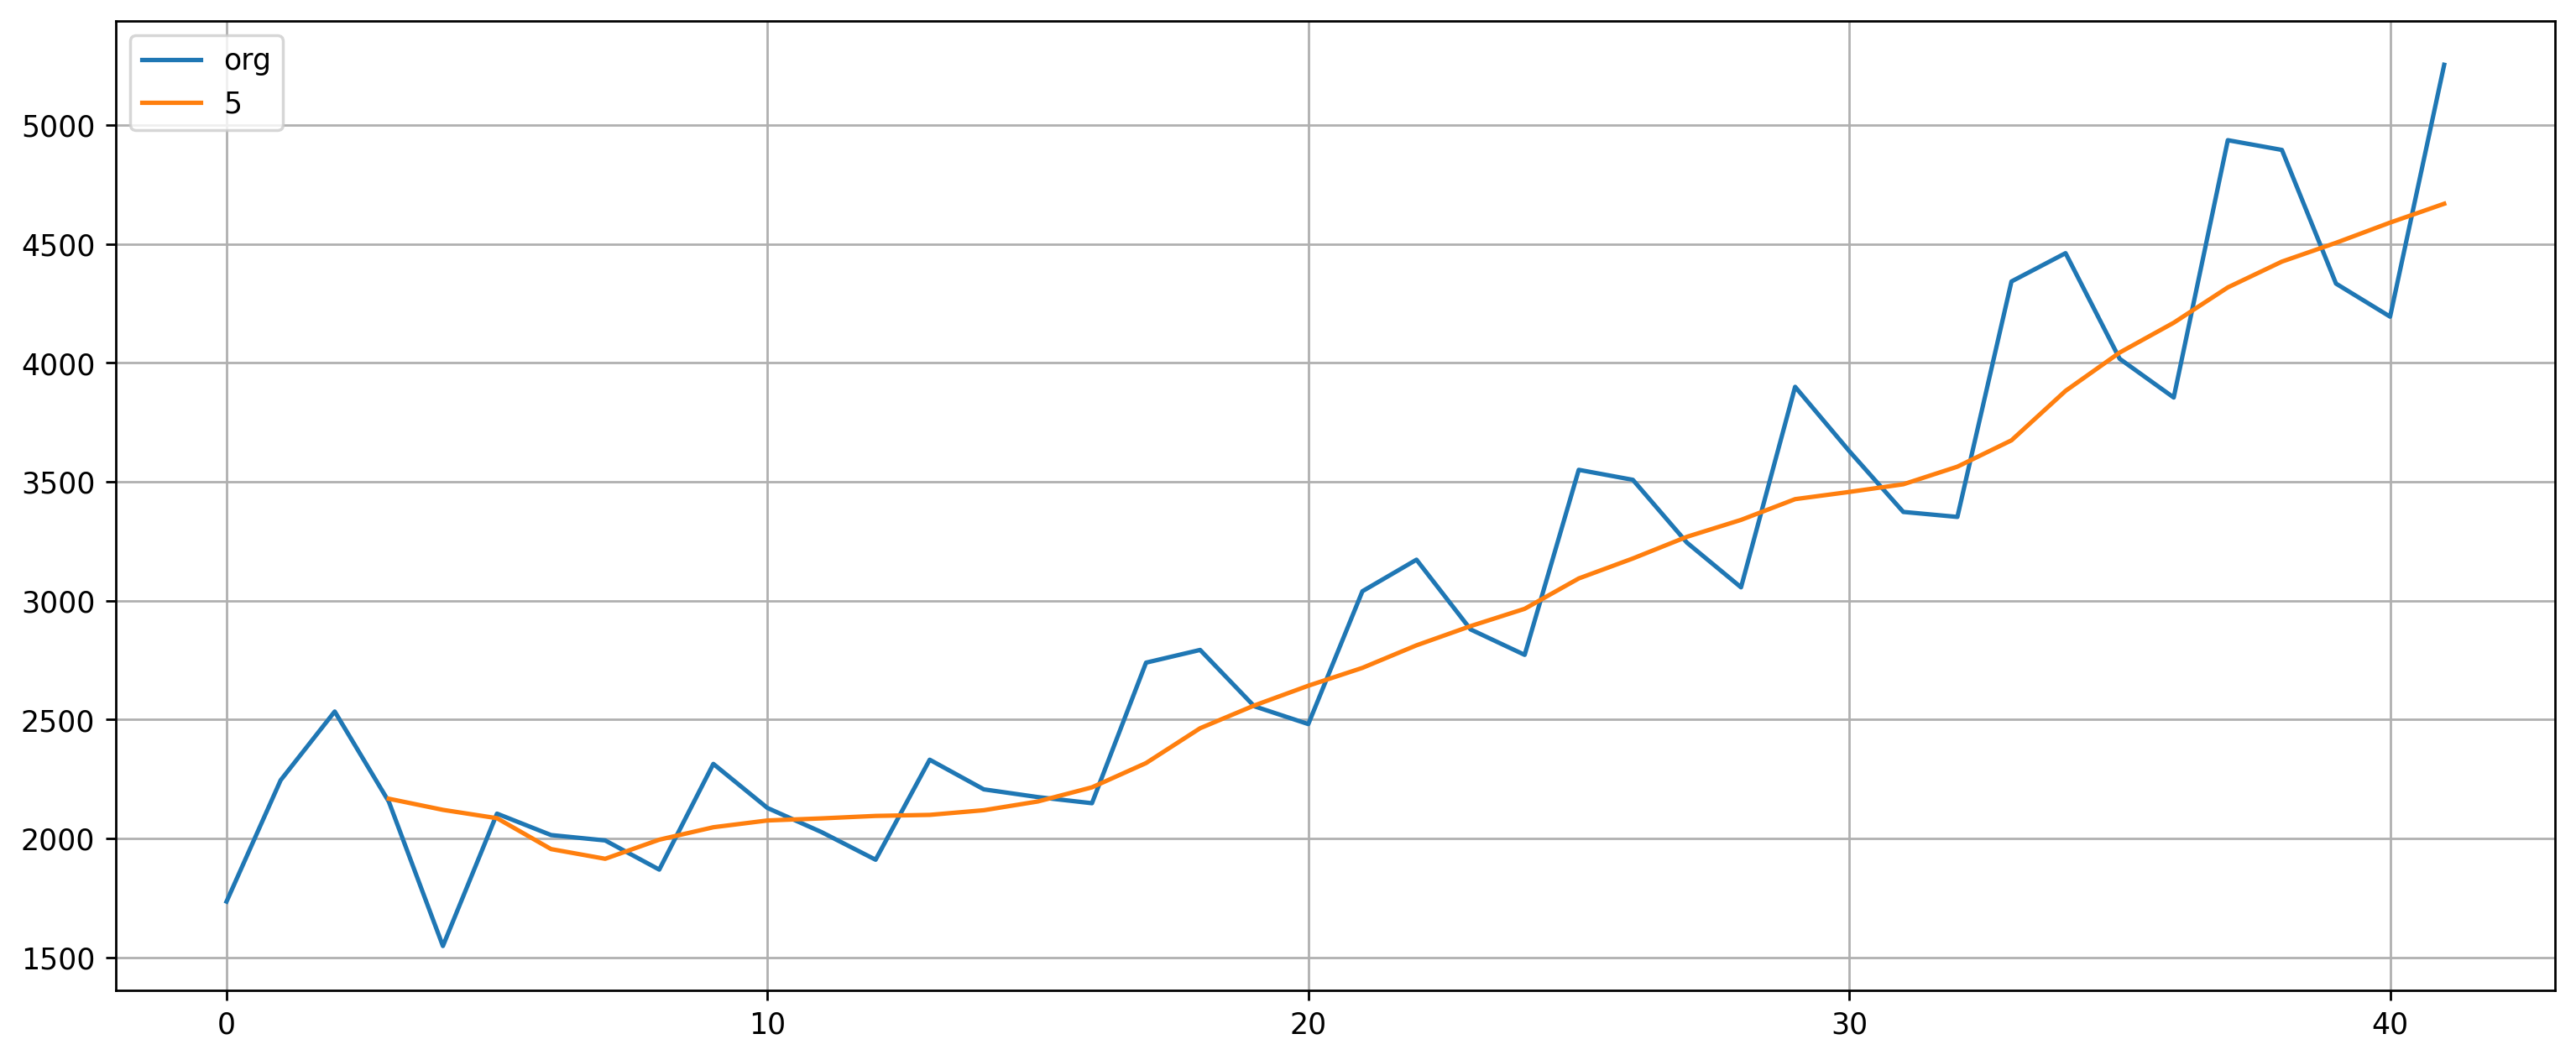

In [45]:
# Plotting Moving Average 
plt.figure(figsize=(15,6),dpi=250)
coke['Sales'].plot(label="org")
coke["Sales"].rolling(4).mean().plot(label=str(5))
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

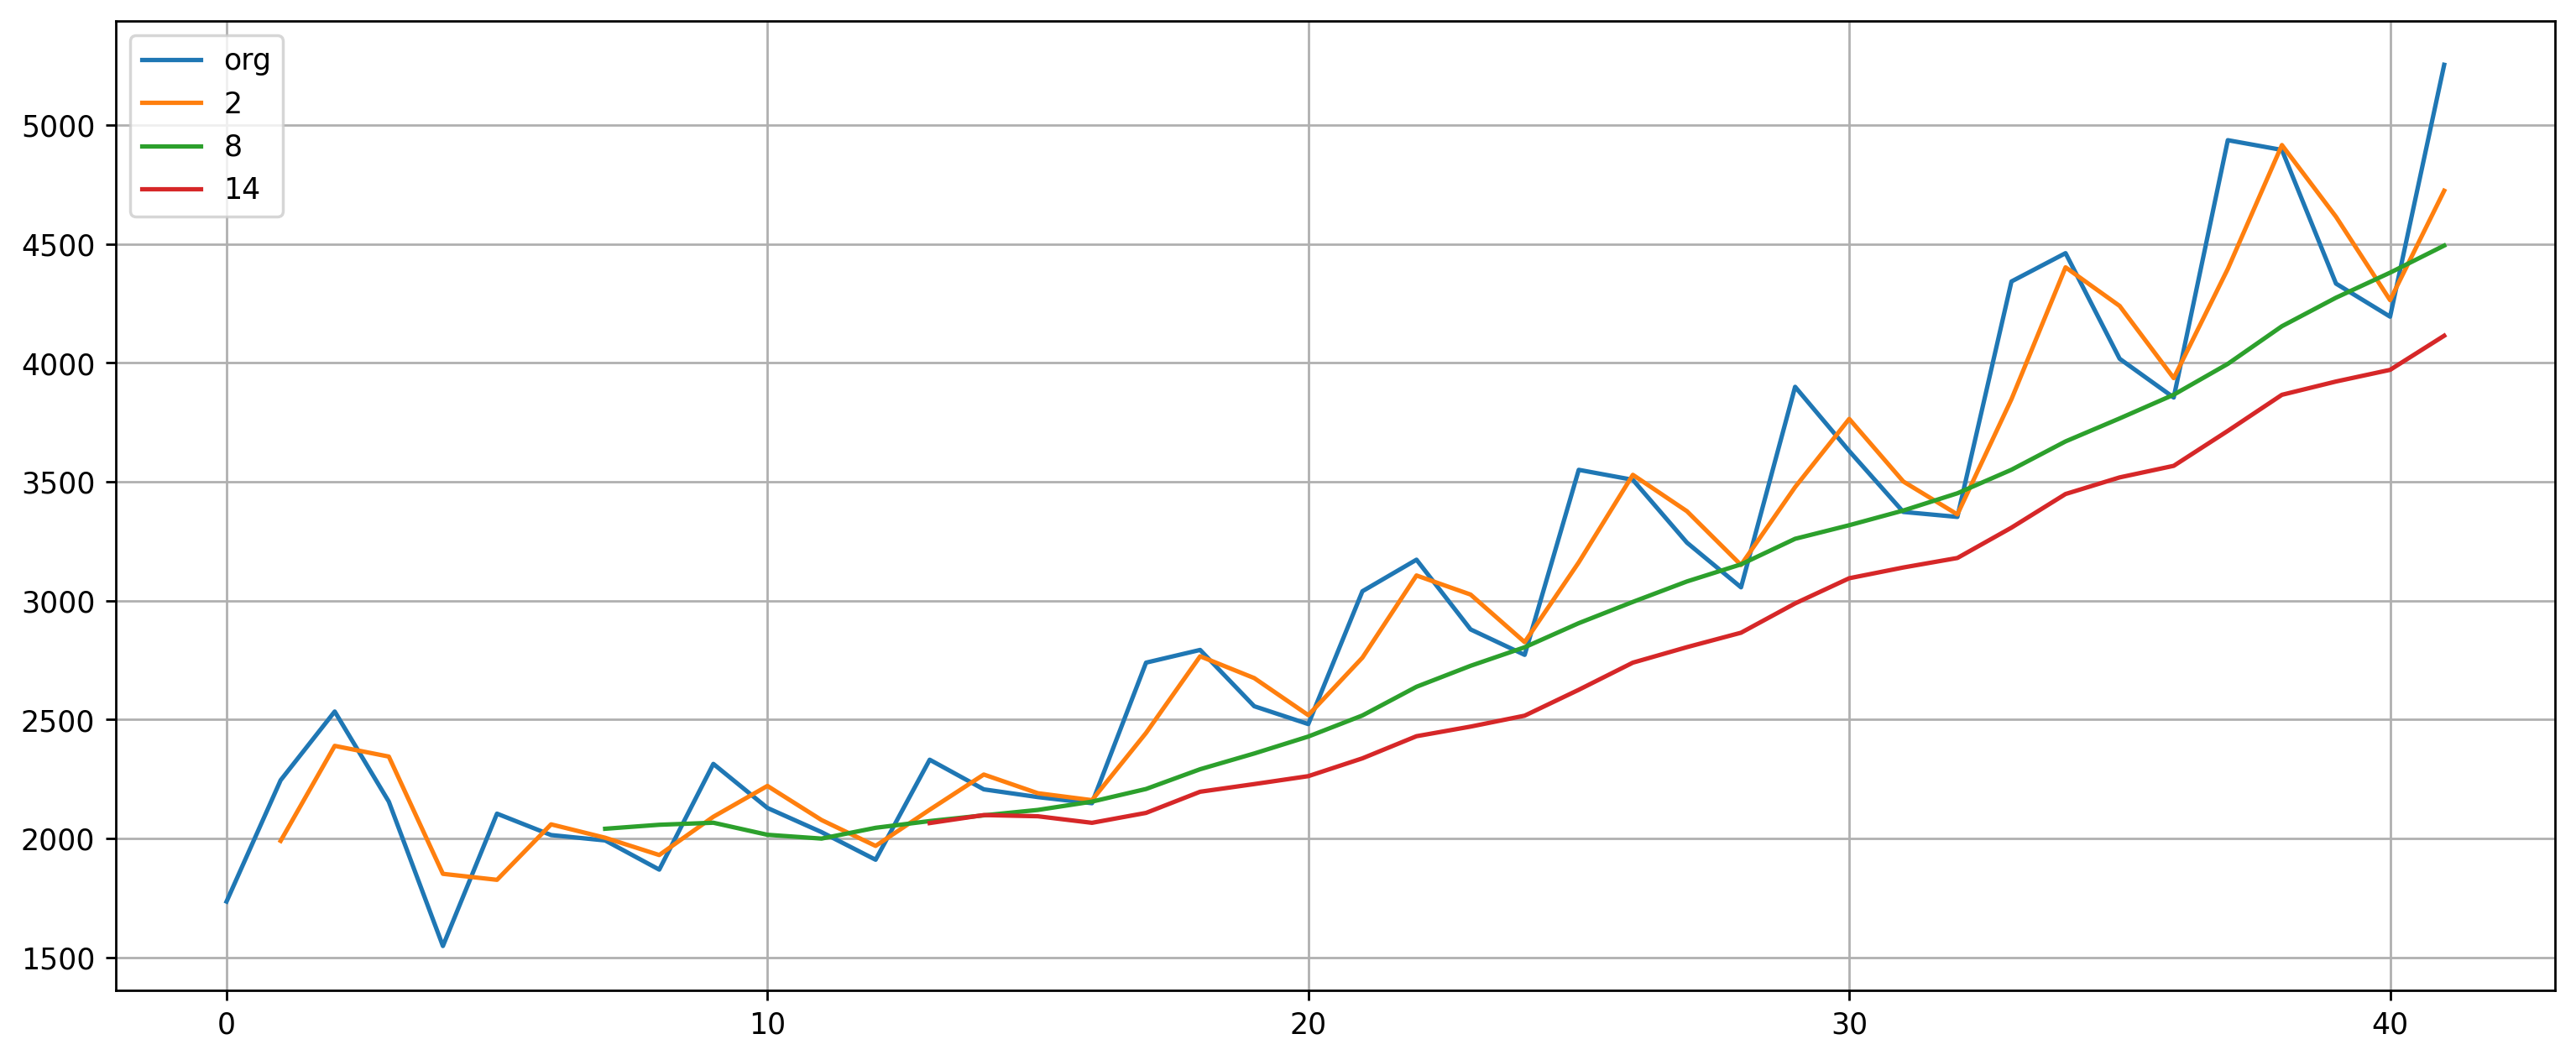

In [47]:
plt.figure(figsize=(15,6),dpi=250)
coke['Sales'].plot(label="org")
for i in range(2,18,6):
    coke["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.grid(True)
plt.show()

<Figure size 1600x1200 with 0 Axes>

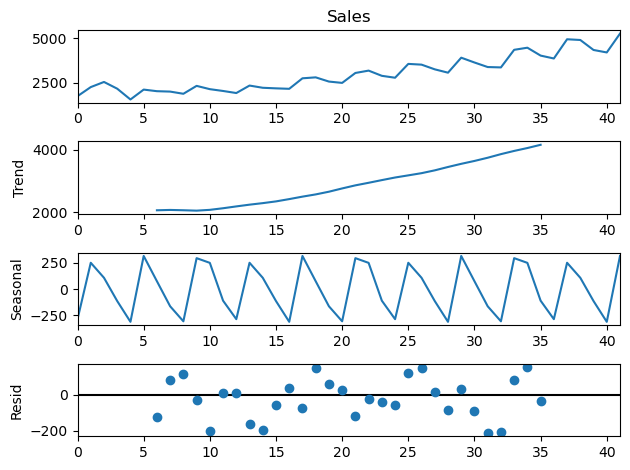

In [48]:
# Time series decomposition plot 
plt.figure(dpi=250)
decompose_ts_add = seasonal_decompose(coke['Sales'], period=12)
decompose_ts_add.plot()
plt.show()

<Figure size 3750x1000 with 0 Axes>

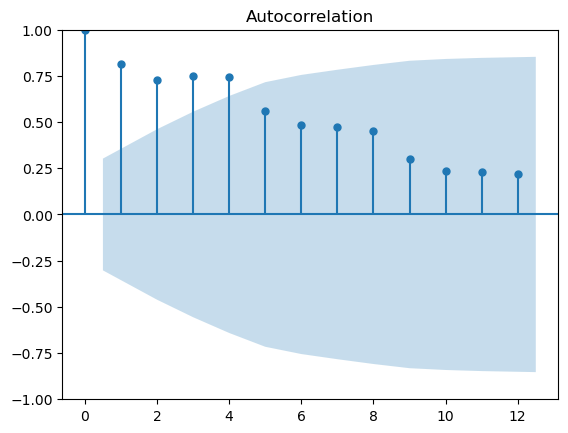

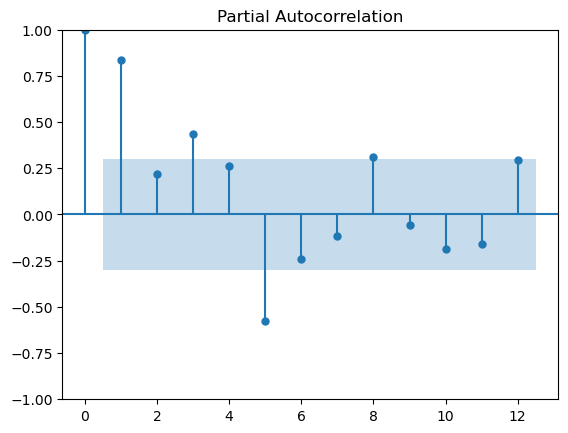

In [62]:
# Plotting ACF & PACF plots
plt.figure(figsize=(15,4),dpi=250)
tsa_plots.plot_acf(coke.Sales,lags=12)
tsa_plots.plot_pacf(coke.Sales,lags=12)
plt.show()

In [52]:
# Splitting data train & test sets
train = coke.head(35)
test = coke.tail(7)

**Mean Absolute Percentage Error (MAPE) :**

In [53]:
# Creating function for MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

**Simple Exponential Method :**

In [54]:
ses_model = SimpleExpSmoothing(train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start=test.index[0], end=test.index[-1])
print('MAPE :',MAPE(pred_ses,test.Sales) )

MAPE : 16.401824883031278


**Holt Method :**

In [55]:
hw_model = Holt(train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start=test.index[0], end=test.index[-1])
print('MAPE :',MAPE(pred_hw,test.Sales))

MAPE : 15.89143419747238


**Holts winter exponential smoothing with additive seasonality and additive trend :**

In [56]:
# Adding the trend to the model
hwe_model_add_add = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
print('MAPE :',MAPE(pred_hwe_add_add,test.Sales))

MAPE : 5.060247468194667


**Holts winter exponential smoothing with multiplicative seasonality and additive trend :**

In [57]:
hwe_model_mul_add = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
print('MAPE :',MAPE(pred_hwe_mul_add,test.Sales))

MAPE : 4.691537207011229


**Final Model by combining train & test sets :**

In [58]:
hwe_model_mul_add = ExponentialSmoothing(coke["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 

In [60]:
# Forecasting for next 7 time periods
hwe_model_mul_add.forecast(7)

42    5035.865417
43    4697.002094
44    4561.261773
45    5743.610588
46    5791.921250
47    5232.966193
48    4975.850523
dtype: float64